## Anomaly detection using Lightweight Online Detector of Anomalies (LODA) with CuPy and RAPIDS. 

### Authors:
Tadesse ZeMicheal (Nvidia)
### Introduction

Anomaly detection is an important problem that has been studied within wide areas and application domains. Several anomaly detection algorithms are generic, while many are developed specifically to the domain of interest. In practice, several ensemble-based anomaly detection algorithms have been shown to have superior performance on many benchmark datasets, namely Isolation Forest, Lightweight Online Detector of Anomalies (LODA), and an ensemble of Gaussian mixture models ...etc.

The Loda algorithm is one of the high performing generic anomaly detection algorithms. Loda detects anomalies in a dataset by computing the likelihood of each point using an ensemble of one-dimensional histograms. These histograms approximate the joint probability of the data using sparse random projections. For convenience, negative log-likelihood (NLL) is used as scoring criteria, where large NLL value indicates an instance as anomalous. Since anomalies are expected to be points with smaller likelihood under the fitted probability model (the histograms in this case). 

Loda is a good candidate to use for many cybersecurity use case because of being computationally fast. It is linear with respect to training sample $n$ and dimension $d$. Additionally, Loda is easy to update in real-time from a stream of data by implementating the histogram as an [online-histograms](https://jmlr.org/papers/volume11/ben-haim10a/ben-haim10a.pdf). This makes it an attractive choice to use in the domain of concept drifts, such as intrusion detection, behavioral analytics, sensor outages ...etc, where a large stream of data is expected in online streams. 

In simple term Loda is constructed as $k$ one-dimensional histograms ${h}^k_{i=1}$, where each histogram approximate probability density $p$ of input data projected into one-dimensional sparse projection vector $\{w_i \in R^d\}^k_{i=1}$. The histogram are set as fixed-width and the number of bins are set as hyperparameter or computed heuristically. The algorithm works as follows, first it constructs projection vector $w_i$ by starting all-zero vector, selecting $k=\sqrt{d}$ features at random, and replacing this with random number generated from standard normal distribution. Then a training example $X$ is projected to the real lines as $w^T_iX$, and a fixed-width histogram density estimator $p_i$ is estimated from the projected data. 

To compute anomaly score of a query point $X_q$, Loda computes the average negative log likelihood (NLL) as follows: $$f(X_q) = \frac{1}{k}\sum_i^k -\log p_i(w_i^TX_q)$$

### Implementation 

Loda being a projection based algorithm makes it a good choice to use GPUs for the matrix operations. For both training and inference, the ensemble of random projection vectors $w^T_iX$ can be implemented efficiently using cupy and parallelize across GPUs for further acceleration.

In [2]:
import cupy as cp 
import cudf, cuml 
import numpy as np 
import matplotlib.pylab as plt 
import cuxfilter as cf 
import cuml.metrics as mt 
%matplotlib inline 


In [3]:
class Loda(object):

    def __init__(self,  n_bins=None, n_random_cuts=100):
        """
        n_bins (int): Number of bins for each histogram. If None a heurstic is used to compute the number of bins. 
        n_random_cuts (int): Number of projection to use. 
        """
        self.n_bins = n_bins
        self.n_random_cuts = n_random_cuts
        self.weights = cp.ones(n_random_cuts) / n_random_cuts
        self.projections = None 
        self.histograms = None 
        self.limits = None 

    def fit(self, X, y=None):

        """ Fit training data and  construct histogram.
        
        The type of histogram is 'regular', and right-open
        Note: If n_bins=None, the number of breaks is being computed as in:
        L. Birge, Y. Rozenholc, How many bins should be put in a regular histogram? 2006
        """
        nrows, n_components = X.shape 
        
        # number of bins to use. 
        if not self.n_bins:
            self.n_bins = int(1 * (nrows ** 1) * (cp.log(nrows) ** -1))
        n_nonzero_components = cp.sqrt(n_components)
        n_zero_components = n_components - cp.int(n_nonzero_components)

        self.projections = cp.random.randn(self.n_random_cuts, n_components)
        self.histograms = cp.zeros([self.n_random_cuts, self.n_bins])
        self.limits = cp.zeros((self.n_random_cuts, self.n_bins + 1))
        for i in range(self.n_random_cuts):
            rands = cp.random.permutation(n_components)[:n_zero_components]
            self.projections[i, rands] = 0.
            projected_data = self.projections[i, :].dot(X.T)
            self.histograms[i, :], self.limits[i, :] = cp.histogram(projected_data, bins=self.n_bins, density=False)
            self.histograms[i, :] += 1e-12
            self.histograms[i, :] /= cp.sum(self.histograms[i, :])
        return self

    def score(self, X):
        
        if cp.ndim(X) < 2:
            X = X.reshape(1,-1)
        pred_scores = cp.zeros([X.shape[0], 1])
        for i in range(self.n_random_cuts):
            projected_data = self.projections[i, :].dot(X.T)
            inds = cp.searchsorted(self.limits[i, :self.n_bins - 1], projected_data, side='left')
            pred_scores[:, 0] += -self.weights[i] * cp.log(self.histograms[i, inds])
        pred_scores /= self.n_random_cuts
        return pred_scores.ravel()

    def instance_score(self, x, projection_index):
        """
            Return scores from selected projection index. 
            x (cupy.ndarray) : D x 1 feature instance. 

        """
        if cp.ndim(x) < 2:
            x = x.reshape(1,-1)
        pred_scores = cp.zeros([x.shape[0], len(projection_index)])
        for i in projection_index:
            projected_data = self.projections[i, :].dot(x.T)
            inds = cp.searchsorted(self.limits[i, :self.n_bins - 1], projected_data, side='left')
            pred_scores[:, i] = -self.weights[i] * cp.log(self.histograms[i, inds])
        
        return pred_scores


    def t_test(self, with_sample, without_sample):
        """
        compute one-tailed two-sample t-test with a test statistics according to
            t_j: \frac{\mu_j - \bar{\mu_j}}{\sqrt{\frac{s^2_j}{\norm{I_j}} + \frac{\bar{s^2_j}}{\norm{\bar{I_j}}}}}
        """
        
        return (cp.mean(with_sample) - cp.mean(without_sample)) / cp.sqrt(cp.var(with_sample)**2 / len(with_sample) + cp.var(without_sample)**2 / len(without_sample))

    def explain(self, x, scaled=True):
        # Return explanation of the anomalies based on the projection vectors. 
     
        # iterate each features and compare the score. 
        '''
        Let v_j : vector scores from projections that only involves feature j.
        Let v_nj: vector scores from projections that don't include feature j.
              
        Order the score of each feature based on the scores, the higher the score is the more important the feature it is. 
        
        '''
        if cp.ndim(x) < 2:
            x = x.reshape(1, -1)
        ranked_feature_importance = cp.zeros([x.shape[1],1])
        
        for feature in range(x.shape[1]):
            # find all projections without the feature j and with feature j
            index_selected_feature = cp.where(self.projections[:,feature] != 0)[0]
            index_not_selected_feature = cp.where(self.projections[:, feature] == 0)[0]
            scores_with_feature = self.instance_score(x, index_selected_feature)
            scores_without_feature = self.instance_score(x, index_not_selected_feature)
            ranked_feature_importance[feature, 0] = self.t_test(scores_with_feature, scores_without_feature)
        
        if scaled:
            assert cp.max(ranked_feature_importance) != cp.min(ranked_feature_importance)
            normalized_score = (ranked_feature_importance - cp.min(ranked_feature_importance)) / (cp.max(ranked_feature_importance) - cp.min(ranked_feature_importance))
            return  normalized_score
        else:
            return ranked_feature_importance


### Dataset
To test the implementation of the algorithm we use anomaly dataset benchmark from [UCI dataset](https://archive.ics.uci.edu/ml/datasets.php). For this particular example we use the Statlog (shuttle) dataset. The dataset consistst of 9 features with approximately 80% belong to nominal class and remaining to anomaly class. In the following experiment we evaluate the Loda algorithm how good is in ranking the anomalies over the nominal class.  


In [6]:
df = cudf.read_csv('shuttle.txt')
df.head(5)

,label,v1,v2,v3,v4,v5,v6,v7,v8,v9
0,nominal,49,-1,77,0,50,5,28,28,0
1,nominal,40,1,88,0,38,0,47,49,2
2,nominal,37,0,77,0,-2,-17,41,80,40
3,nominal,37,0,83,0,2,18,46,80,34
4,nominal,55,0,83,0,56,25,27,26,0


In [7]:
print(f"Size of the dataset {df.shape}")

Size of the dataset (12345, 10)


In [8]:
y, x = (df.iloc[:, 0] == "anomaly").astype('int'), df.iloc[:, 1:].values

Utility function to compute metrics.

In [69]:
def average_precision_score(y_true, y_score):
    """
    Compute average precision score using precision and recall computed from cuml. 
    """
    precision, recall, _ = mt.precision_recall_curve(y_true, y_score) #, pos_label=pos_label, sample_weight=sample_weight)
    # return step function integral 
    return -cp.sum(cp.diff(recall) * cp.array(precision)[:-1])

def metrics(y_true, y_score):
    auc = mt.roc_auc_score(y_true=y_true, y_score=y_score)
    ap = average_precision_score(y_true, y_score)
    # ap = mt.average_precision_score(y_true, y_score) # future implementation. 
    return [auc, ap]

#### Training and Scoring 
Training Loda involves two steps, first projecting training sample into $|w|$ projections and fitting the projected data ($W^TX$) into $k$ histograms crossponding to each vector without any supervision. We set the parameter for the number of projections (`n_random_cuts`) and the number of bins (equil width bins) or optionally use heuristic to determine the number of bins.

Once the histograms are fitted (Loda is trained), these  histogram serve as an ensemble of weak anomaly detectors by estimating the density of the random projected vectors. Combining these `n_random_cuts` histograms leads to a strong anomlay detector where the negative likelihood across the histograms serves as anomaly scores. 

In [9]:
# Fit loda with 500 random projections and number of bins are computed heuristically
ld = Loda(n_random_cuts=500, n_bins=None) 
ld = ld.fit(x) # train the detector

### Evaluate benchmark dataset
We compute AUC and average precision score to evaluate the performance of the detector. We use  `cuml.metrics` to compute both AUC and average precision score (AP).

In [10]:
score = ld.score(x) #generate nll scores
print(score)

[0.0088822  0.0077992  0.01178373 ... 0.01066062 0.01282569 0.00878747]


In [11]:
print(f"AUC and Average precision {metrics(y, score)}") # compute auc and pr 

AUC and Average precision [0.9897273778915405, array(0.78787544)]


### Explanation of anomalies 

To explain the cause of anomalies Loda utilize contributions of each feature across the histograms. Recognize that each histogram $H$ are made with sparse projections $w$, this method can be used to rank each features according to their contributions to the instance anomalousness. To measure the importance of a particular feature, the anomaly score difference is computed from all histograms when the feature is selected in the projection from all the histograms when the feature is not selected. This allows to measure how influential the feature is in isolating an instance as anomaly. 

Let $I_j$ denotes a vector score of histograms that use feature $j$, and let $\bar{I}_j$ be the vector score of histograms that don't use feature $j$ and suppose the corresponding mean and variance of the scores are denoted as ($\mu_j, s^2_j$)and $(\bar{\mu_j},\bar{s^2_j})$ respectively.  Then anomaly explanation of a feature is given by one-tailed two-sample $t$ test with a test statistics given as follows. 
$$t_j: \frac{\mu_j - \bar{\mu}_j}{\sqrt{\frac{s^2_j}{I_j} + \frac{\bar{s}^2_j}{\bar{I}_j}}}$$

The purpose of this score function is to assert if the contribution of a feature $j$ is statistically significant on isolating the instance as anomalies. Larger t-score indicates the more influence the feature has on identifying the instance as anomaly. We rank each feature based on their $t_{score}$ to output the most influential features for the anomalousness of the instance.  


Sort top instance based on their anomaly scores.

In [12]:
ordered_score = cudf.DataFrame() 
ordered_score['label'] = df.label
ordered_score['score'] = score
ordered_score = ordered_score.sort_values( by='score', ascending=False)
#ordered_score = ordered_score.sort_values(column = 'score')

In [13]:
ordered_score.head(5)

,label,score
780,anomaly,0.052504
3680,anomaly,0.044255
3066,anomaly,0.040473
10874,anomaly,0.039394
12013,anomaly,0.038506


To generate an explanation we will take examples of top ranked anomalies. 

In [60]:
selected_anomaly = df.iloc[780, 1:]

In [61]:
selected_anomaly

v1      79
v2       0
v3      83
v4       0
v5      98
v6    8098
v7       4
v8     -14
v9     -18
Name: 780, dtype: int64

In [62]:
# Check explanation from Loda
feature_explanation = ld.explain(selected_anomaly.values)

In [63]:
print(f"Feature importance scores: {feature_explanation.ravel()}")

Feature importance scores: [0.22769142 0.         0.22228638 0.18947137 0.58514364 1.
 0.32871521 0.51769215 0.44673791]


The t-score values are normalized between 0 and 1, the plot below shows comparison of each features influence for the selected example. Clearly, feature $V6$ has higher influence followed by feature $V5$ and $V8$. 

Text(0.5, 0, 'Features')

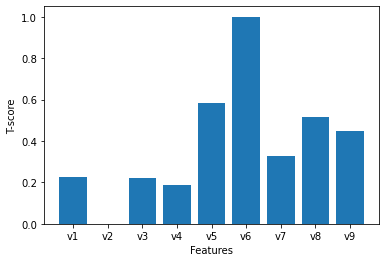

In [65]:
# plot the contribution of each features. 
plt.bar(df.columns[1:], feature_explanation.ravel().get())
plt.ylabel('T-score')
plt.xlabel('Features')

To test the explanation, we can check how each feature of the selected example is deviated from the median feature value. We use median abosolute deviation (MAD) to measure how far is each feature from its normalized MAD score. MAD = $median(|x - median(x)|)$

In [56]:
def mad(x, axis=1):
    # return median absolute deviation 
    standard_scale = 0.67448975
    return cp.median(cp.abs(x - cp.median(x, axis=axis)), axis=axis)/standard_scale


In [66]:
median_absolute_deviation_features = mad(x, axis=0)

In [67]:
mad_distance = selected_anomaly.values - median_absolute_deviation_features
print(f'Deviation of each features from mad {mad_distance}')

Deviation of each features from mad [ 6.86217845e+01  0.00000000e+00  7.70695911e+01  0.00000000e+00
  8.61391822e+01  8.09058699e+03 -3.41301109e+00 -2.43782155e+01
 -2.09652044e+01]


### Conclusion
In this notebook we show a GPU implementation of Loda algorithm for anomaly detection and explanation. We evaluate the implementation on anomaly benchmark dataset to identify anomalies and explain the features that cause for its identification using RAPDIS. 

## Reference
- [Loda: Lightweight on-line detector of anomalies](https://link.springer.com/article/10.1007/s10994-015-5521-0)
- [PyOD: A Python Toolbox for Scalable Outlier Detection](https://www.jmlr.org/papers/volume20/19-011/19-011.pdf)
- [Anomaly Detection in the Presence of Missing Values](https://arxiv.org/pdf/1809.01605.pdf)
- https://archive.ics.uci.edu/ml/datasets/Statlog+%28Shuttle%29